In [1]:
# Unused Imports
# from sklearn.preprocessing import StandardScaler

In [5]:
import wget
import os.path
from os import path
if(not path.exists("data/control.xls")):
    wget.download("https://raw.githubusercontent.com/smithandrewk/sleep/main/data/control.xls","data/control.xls")
if(not path.exists("data/deprivation.xls")):
    wget.download("https://raw.githubusercontent.com/smithandrewk/sleep/main/data/deprivation.xls","data/deprivation.xls")
# TODO: get utils
if(not path.exists("scripts/utils.py")):
    wget.download("https://raw.githubusercontent.com/smithandrewk/sleep/main/scripts/utils.py","data/utils.py")

In [7]:
from scripts.utils import *
df = preprocess("control")
## Statistics
# df.describe() # nice for obtaining statistics over dataframe
p,s,w = np.bincount(df['Class'])
total = p + s + w
print('Examples:\n    Total: {}\n    P: {} ({:.2f}% of total)\n    S: {} ({:.2f}% of total)\n    W: {} ({:.2f}% of total)\n'.format(
    total, p, 100 * p / total,s,100 * s / total,w,100 * w / total))

Examples:
    Total: 8641
    P: 367 (4.25% of total)
    S: 3965 (45.89% of total)
    W: 4309 (49.87% of total)



In [8]:
import sklearn
from sklearn.model_selection import train_test_split
df = pd.read_csv("data/control_preprocessed.csv")

# Use a utility from sklearn to split and shuffle our dataset.
train_df, test_df = train_test_split(df, test_size=0.2)
# train_df, val_df = train_test_split(train_df, test_size=0.2)

# Form np arrays of labels and features.
train_labels = np.array(train_df.pop('Class'))
p_train_labels = train_labels == 0
s_train_labels = train_labels == 1
w_train_labels = train_labels == 2

# val_labels = np.array(val_df.pop('Class'))
test_labels = np.array(test_df.pop('Class'))

train_features = np.array(train_df)
# val_features = np.array(val_df)
test_features = np.array(test_df)

In [9]:
import tensorflow as tf
from tensorflow import keras
def get_compiled_model(n,dropout=True):
    """
    Function to create model. This is a sequential model, meaning layers execute
    one after the other. We have an input shape corresponding to the feature set,
    one hidden layer with 10 neurons and a relu activation, then an output layer
    with 3 neurons and a sigmoid activation function. We compute loss with
    categorical crossentropy and optimize with adam, which I believe is something
    about an adaptive learning rate. I do not know what the parameter from_logits
    is about.
    """
    if(dropout):
        model = tf.keras.Sequential([
        keras.layers.Dense(n, activation='relu',input_shape=(train_features.shape[-1],)),
        keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(3, activation='sigmoid')
        ])
    else:
        model = tf.keras.Sequential([
        keras.layers.Dense(n, activation='relu',input_shape=(train_features.shape[-1],)),
        tf.keras.layers.Dense(3, activation='sigmoid')
        ])
    model.compile(optimizer=keras.optimizers.Adam(lr=1e-3),
                loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])
    return model
EPOCHS = 100
BATCH_SIZE = 200
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='accuracy', 
    verbose=1,
    patience=100,
    mode='max',
    restore_best_weights=True)

In [6]:
model = get_compiled_model(2000,dropout=True)
"""
We one-hot encode the targets. Mathematically, this is good for calculating
loss. CategoricalCrossEntropy simplifies to a negative log when targets are
one-hot encoded. However, I simply recieved an error from model.fit when I 
did not one-hot encode.
  @y : targets
  @depth : number of targets
"""
baseline_history = model.fit(
    train_features,
    tf.one_hot(train_labels,depth=3),
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early_stopping])

Epoch 1/100
35/35 [==============================] - 0s 4ms/step - loss: 10.9103 - accuracy: 0.6230
Epoch 2/100
35/35 [==============================] - 0s 4ms/step - loss: 7.5522 - accuracy: 0.7899
Epoch 3/100
35/35 [==============================] - 0s 4ms/step - loss: 8.1060 - accuracy: 0.7659
Epoch 4/100
35/35 [==============================] - 0s 4ms/step - loss: 1.7810 - accuracy: 0.8001
Epoch 5/100
35/35 [==============================] - 0s 4ms/step - loss: 5.2901 - accuracy: 0.8113
Epoch 6/100
35/35 [==============================] - 0s 5ms/step - loss: 3.5155 - accuracy: 0.8146
Epoch 7/100
35/35 [==============================] - 0s 5ms/step - loss: 5.4075 - accuracy: 0.8163
Epoch 8/100
35/35 [==============================] - 0s 5ms/step - loss: 6.2837 - accuracy: 0.8227
Epoch 9/100
35/35 [==============================] - 0s 5ms/step - loss: 1.8319 - accuracy: 0.8405
Epoch 10/100
35/35 [==============================] - 0s 5ms/step - loss: 3.1730 - accuracy: 0.8501
Epoch 11

loss :  3.488145351409912
accuracy :  0.8768073916435242



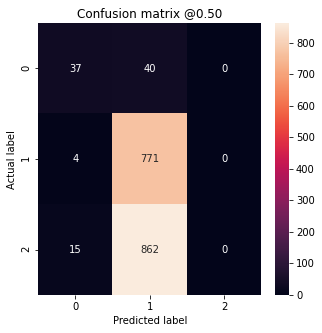

In [7]:
train_predictions_baseline = model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_baseline = model.predict(test_features, batch_size=BATCH_SIZE)

baseline_results = model.evaluate(test_features, tf.one_hot(test_labels,depth=3),
                                  batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(model.metrics_names, baseline_results):
  print(name, ': ', value)
print()

plot_cm(tf.one_hot(test_labels,depth=3).numpy().argmax(axis=1), test_predictions_baseline.argmax(axis=1))